# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

import rdtools


# 1. <b>Standardize</b>

Please download the site data from Site 89, and unzip the csv file in the folder:
./rdtools/docs/

http://dkasolarcentre.com.au/historical-data/download

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



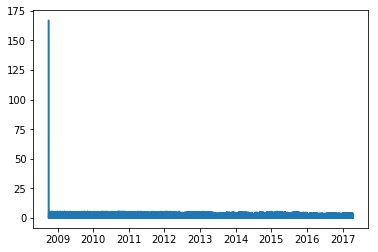

In [10]:
file_name = '89-Site_5-Kyocera.csv'




df_raw = pd.DataFrame.from_csv(file_name, index_col=0, parse_dates=True)

dt = pd.date_range(df_raw.index[0], df_raw.index[-1], freq='15min')
df = pd.DataFrame(index=dt)

df['ac power'] = df_raw.iloc[:,2]
df['ghor'] = df_raw.iloc[:,8]
df['tamb'] = df_raw.iloc[:,6]


plt.plot(df['ac power'])
plt.show()

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

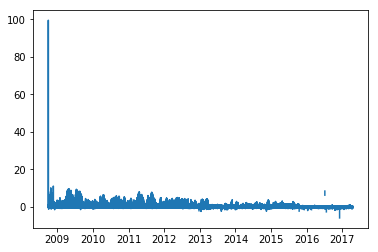

In [11]:
meta = {"altitude":0,
       "latitude": -23.761878,
       "longitude": 133.874846,
       "Name": "Alice Springs",
       "State": "n/a",
       "TZ": 8.5}

pv = pvlib.pvsystem.systemdef(meta, -10, 0, albedo=0.2, modules_per_string=7, strings_per_inverter=5)


pvwatts_kws = {"poa_global" : df['ghor'],
              "P_ref" : 10.5,
              "T_cell" : df['tamb'],
              "G_ref" : 1000,
              "T_ref": 25,
              "gamma_pdc" : -0.0041}

normalized = rdtools.normalize_with_pvwatts(df['ac power'], pvwatts_kws)

plt.plot(normalized)
plt.show()

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


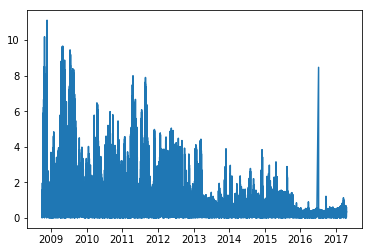

In [13]:

filtered = normalized[(normalized > 0) & (normalized < 20)]


plt.plot(filtered)
plt.show()


# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.


In [14]:
ols = rdtools.degradation.degradation_ols(filtered)
print "degradation_ols", ols

yoy = rdtools.degradation.degradation_year_on_year(filtered)
print "degradation_year_on_year", yoy



degradation_ols {'slope': -0.05824680861840445, 'intercept': 0.72810496454554097, 'Rd_pct': -7.9997818246933923, 'rmse': 0.42948329769677146, 'Rd_CI': array([-8.04342199, -7.95531324]), 'slope_stderr': 0.0004666446037950612, 'intercept_stderr': 0.0022983005616094474, 'ols_result': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000000001ED0A2B0>}

Degradation and 68% confidence interval YOY approach:
YOY1: Rd = -8.84 +/- 2.19
degradation_year_on_year {'Rd_stderr_pct': 2.1899999999999999, 'Rd_median': -8.8353607328861123, 'YoY_filtered': [-3.0754340184699078, -1.3779918810126677, 13.426268316636056, 14.224276499699123, -5.7723216063728451, 32.534298440294179, -2.8399719598539335, 40.422873601905756, 2.9952457754684727, -15.607541075930317, -2.8229574527325383, -17.194895056007983, -35.285501062487278, 4.9450423975588773, -20.618833320580567, -30.43592447831432, -28.441590678456301, 8.7902689991252316, -42.159356148209426, -37.089061519817292, -59.24104915774118